Import useful classes

In [1]:
from src.model import RNN, LSTM, CNN, CNN1d, BERTGRUSentiment, Trainer
from transformers import BertModel

One of the main concepts of TorchText is the Field. These define how your data should be processed. In our sentiment classification task the data consists of both the raw string of the review and the sentiment, either "pos" or "neg".
The parameters of a Field specify how the data should be processed. We use the TEXT field to define how the review should be processed, and the LABEL field to process the sentiment.
Our TEXT field has tokenize='spacy' as an argument. This defines that the "tokenization" (the act of splitting the string into
discrete "tokens") should be done using the spaCy tokenizer. If no tokenize argument is passed, the default is simply splitting the string on spaces.
LABEL is defined by a LabelField, a special subset of the Field class specifically used for handling labels. We will explain the dtype argument later.
Another handy feature of TorchText is that it has support for common datasets used in natural language processing (NLP) such as IMDb dataset

In the following, we will proceed as follows:
- We'll define our model and pass it on to our trainer...
- Then we will compile our trainer, which will load the data, build the optimizer and the loss function, and update the model parameters if necessary.
- After that we will review some specificities (model, data...) of our trainer when necessary.
- We'll continue by training and testing our model. 
- And finally, we'll test our model on a few real-life cases.

See the src/model.py script for more details.

# RNN

### Implementation Details

our `RNN` class is a sub-class of `nn.Module` and the use of `super`.

Within the `__init__` we define the _layers_ of the module. Our three layers are an _embedding_ layer, our RNN, and a _linear_ layer. All layers have their parameters initialized to random values, unless explicitly specified.

The embedding layer is used to transform our sparse one-hot vector (sparse as most of the elements are 0) into a dense embedding vector (dense as the dimensionality is a lot smaller and all the elements are real numbers). This embedding layer is simply a single fully connected layer. As well as reducing the dimensionality of the input to the RNN, there is the theory that words which have similar impact on the sentiment of the review are mapped close together in this dense vector space. For more information about word embeddings, see [here](https://monkeylearn.com/blog/word-embeddings-transform-text-numbers/).

The RNN layer is our RNN which takes in our dense vector and the previous hidden state $h_{t-1}$, which it uses to calculate the next hidden state, h_t.

![](assets/sentiment7.png)

Finally, the linear layer takes the final hidden state and feeds it through a fully connected layer, $f(h_T)$, transforming it to the correct output dimension.

The `forward` method is called when we feed examples into our model.

Each batch, `text`, is a tensor of size _**[sentence length, batch size]**_. That is a batch of sentences, each having each word converted into a one-hot vector. 

You may notice that this tensor should have another dimension due to the one-hot vectors, however PyTorch conveniently stores a one-hot vector as it's index value, i.e. the tensor representing a sentence is just a tensor of the indexes for each token in that sentence. The act of converting a list of tokens into a list of indexes is commonly called *numericalizing*.

The input batch is then passed through the embedding layer to get `embedded`, which gives us a dense vector representation of our sentences. `embedded` is a tensor of size _**[sentence length, batch size, embedding dim]**_.

`embedded` is then fed into the RNN. In some frameworks you must feed the initial hidden state, $h_0$, into the RNN, however in PyTorch, if no initial hidden state is passed as an argument it defaults to a tensor of all zeros.

The RNN returns 2 tensors, `output` of size _**[sentence length, batch size, hidden dim]**_ and `hidden` of size _**[1, batch size, hidden dim]**_. `output` is the concatenation of the hidden state from every time step, whereas `hidden` is simply the final hidden state. We verify this using the `assert` statement. Note the `squeeze` method, which is used to remove a dimension of size 1. 

Finally, we feed the last hidden state, `hidden`, through the linear layer, `fc`, to produce a prediction.

The input dimension is the dimension of the one-hot vectors, which is equal to the vocabulary size. 

The embedding dimension is the size of the dense word vectors. This is usually around 50-250 dimensions, but depends on the size of the vocabulary.

The hidden dimension is the size of the hidden states. This is usually around 100-500 dimensions, but also depends on factors such as on the vocabulary size, the size of the dense vectors and the complexity of the task.

The output dimension is usually the number of classes, however in the case of only 2 classes the output value is between 0 and 1 and thus can be 1-dimensional, i.e. a single scalar real number.

In [2]:
trainer = Trainer(
    model = RNN(
        input_dim = 1, # will be update to len(dataset["TEXT"].vocab) during compilation
        embedding_dim = 100, 
        hidden_dim = 256, 
        output_dim = 1 
    ), 
    dump_path="/home/jupyter/wl_research/wl_research_challenge/dump_path"
)

First, we'll create an optimizer. This is the algorithm we use to update the parameters of the module. Here, we'll use _stochastic gradient descent_ (SGD). 

The loss function here is binary cross entropy with logits. Our model currently outputs an unbound real number. As our labels are either 0 or 1, we want to restrict the predictions to a number between 0 and 1. We do this using the sigmoid or logit functions.
We then use this this bound scalar to calculate the loss using binary cross entropy.
The BCEWithLogitsLoss criterion carries out both the sigmoid and the binary cross entropy steps.

In [3]:
trainer.compile(
    optimizer = "SGD", # algorithm we use to update the parameters of the module
    criterion = "BCEWithLogitsLoss", # loss function
    seed = 1234, # random seeds for reproducibility
    split_ratio = 0.8, # ratio of training data to use for training, the rest for validation
    batch_size = 64, # batch size
    max_vocab_size = 25000 # maximun token in the vocabulary
)

Number of training examples: 4000
Number of validation examples: 5000
Number of testing examples: 25000
Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2
The model has 2,592,105 trainable parameters



In [4]:
print(vars(trainer.dataset["train_data"].examples[0]))

{'text': ['I', 'borrowed', 'this', 'movie', 'because', 'not', 'only', 'because', 'its', 'gay', 'theme', 'but', 'the', 'thought', 'of', 'role', 'playing', 'really', 'intrigued', 'me', '.', 'I', 'was', 'pleasantly', 'surprised', 'that', 'it', 'was', 'shot', 'in', 'San', 'Francisco', 'since', 'I', 'live', 'near', 'SF', '.', 'And', 'of', 'course', 'it', 'was', 'nice', 'to', 'see', 'shots', 'of', 'the', 'Castro', 'district', '(', 'although', 'the', 'castro', 'to', 'me', 'really', 'caters', 'more', 'to', 'gay', 'male', 'than', 'female', ')', '.', 'But', 'other', 'than', 'that', 'I', 'ca', "n't", 'really', 'recommend', 'this', 'movie', '.', 'The', 'characters', 'are', "n't", 'really', 'developed', 'for', 'me', 'to', 'care', 'and', 'when', 'they', 'finally', 'started', 'to', 'get', 'to', 'the', '"', 'role', 'playing', '"', 'I', 'was', 'already', 'bored', 'out', 'of', 'my', 'mind', '.', 'And', 'the', 'role', 'playing', 'scenes', 'that', 'I', 'did', 'see', 'were', 'a', 'bit', 'embarrassing', 'to

Why is the vocab size 25002 and not 25000? One of the addition tokens is the `<unk>` token and the other is a `<pad>` token.

When we feed sentences into our model, we feed a _batch_ of them at a time, i.e. more than one at a time, and all sentences in the batch need to be the same size. Thus, to ensure each sentence in the batch is the same size, any shorter than the longest within the batch are padded.

We can also view the most common words in the vocabulary and their frequencies.

In [5]:
print(trainer.dataset["TEXT"].vocab.freqs.most_common(20))

[('the', 46158), (',', 44809), ('.', 38012), ('and', 25187), ('a', 25157), ('of', 23071), ('to', 21233), ('is', 17599), ('in', 13876), ('it', 12323), ('I', 12216), ('that', 11364), ('"', 10518), ('this', 9850), ("'s", 9839), ('-', 8490), ('was', 8140), ('/><br', 8121), ('as', 6902), ('for', 6733)]


We can also see the vocabulary directly using either the `stoi` (string to int) or `itos` (int to string) method.

In [6]:
print(trainer.dataset["TEXT"].vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


We can also check the labels, ensuring 0 is for negative and 1 is for positive.

In [10]:
print(trainer.dataset["LABEL"].vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


## Train the model

The `train_step` function iterates over all examples, one batch at a time. 

`model.train()` is used to put the model in "training mode", which turns on _dropout_ and _batch normalization_. Although we aren't using them in this model, it's good practice to include it.

For each batch, we first zero the gradients. Each parameter in a model has a `grad` attribute which stores the gradient calculated by the `criterion`. PyTorch does not automatically remove (or "zero") the gradients calculated from the last gradient calculation, so they must be manually zeroed.

We then feed the batch of sentences, `batch.text`, into the model. Note, you do not need to do `model.forward(batch.text)`, simply calling the model works. The `squeeze` is needed as the predictions are initially size _**[batch size, 1]**_, and we need to remove the dimension of size 1 as PyTorch expects the predictions input to our criterion function to be of size _**[batch size]**_.

The loss and accuracy are then calculated using our predictions and the labels, `batch.label`, with the loss being averaged over all examples in the batch.

We calculate the gradient of each parameter with `loss.backward()`, and then update the parameters using the gradients and optimizer algorithm with `optimizer.step()`.

The loss and accuracy is accumulated across the epoch, the `.item()` method is used to extract a scalar from a tensor which only contains a single value.

Finally, we return the loss and accuracy, averaged across the epoch. The `len` of an iterator is the number of batches in the iterator.

You may recall when initializing the `LABEL` field, we set `dtype=torch.float`. This is because TorchText sets tensors to be `LongTensor`s by default, however our criterion expects both inputs to be `FloatTensor`s. Setting the `dtype` to be `torch.float`, did this for us. The alternative method of doing this would be to do the conversion inside the `train` function by passing `batch.label.float()` instad of `batch.label` to the criterion. 

`evaluate` is similar to `train_step`, with a few modifications as you don't want to update the parameters when evaluating.

`model.eval()` puts the model in "evaluation mode", this turns off _dropout_ and _batch normalization_. Again, we are not using them in this model, but it is good practice to include them.

No gradients are calculated on PyTorch operations inside the `with no_grad()` block. This causes less memory to be used and speeds up computation.

The rest of the function is the same as `train`, with the removal of `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()`, as we do not update the model's parameters when evaluating.

In [4]:
stats = trainer.train(
    max_epochs = 50, # maximun number of epochs
    improving_limit = 2, # If the precision of the model does not improve during `improving_limit` epoch, we stop training and keep the best model.
    dump_id = "" # identifier to distinguish models in the serialization folder, is by default equal to the name of the base model
)

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.696 | Train Acc: 49.93%
	 Val. Loss: 0.697 |  Val. Acc: 49.15%
	New best validation score
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.694 | Train Acc: 49.93%
	 Val. Loss: 0.695 |  Val. Acc: 49.31%
	New best validation score
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.694 | Train Acc: 49.18%
	 Val. Loss: 0.695 |  Val. Acc: 50.20%
	New best validation score
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.694 | Train Acc: 47.59%
	 Val. Loss: 0.695 |  Val. Acc: 50.36%
	New best validation score
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.693 | Train Acc: 50.42%
	 Val. Loss: 0.695 |  Val. Acc: 50.34%
	Not a better validation score (0 / 2).
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 0.693 | Train Acc: 49.08%
	 Val. Loss: 0.695 |  Val. Acc: 50.49%
	New best validation score
Epoch: 07 | Epoch Time: 0m 8s
	Train Loss: 0.693 | Train Acc: 49.70%
	 Val. Loss: 0.695 |  Val. Acc: 49.23%
	Not a better validation score (0 / 2).
Epoch: 08 | Epoch Time: 0m 4s

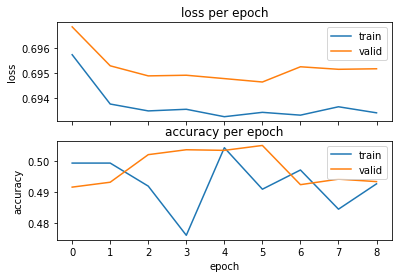

In [5]:
trainer.plot_statistics(statistics = stats)

### Test the model

In [6]:
trainer.test(dump_id = "")

Test Loss: 0.687 | Test Acc: 52.11%


## User Input

In [7]:
predict = trainer.get_predict_sentiment() #.predict_sentiment()

In [8]:
# example negative review...
print(predict(sentence = "This film is too scary, too much gunfire and blood spilled inside. I can't watch bad movies like this anymore."))
# example positive review...
print(predict(sentence = "Among these actors, I prefer the most romantic one, he likes what he does, is positive about chess and knows how to celebrate victories."))

0.564716637134552
0.5561660528182983


# LSTM

### Implementation Details

Another addition to this model is that we are not going to learn the embedding for the `<pad>` token. This is because we want to explitictly tell our model that padding tokens are irrelevant to determining the sentiment of a sentence. This means the embedding for the pad token will remain at what it is initialized to (we initialize it to all zeros later). We do this by passing the index of our pad token as the `padding_idx` argument to the `nn.Embedding` layer.

To use an LSTM instead of the standard RNN, we use `nn.LSTM` instead of `nn.RNN`. Also, note that the LSTM returns the `output` and a tuple of the final `hidden` state and the final `cell` state, whereas the standard RNN only returned the `output` and final `hidden` state. 

As the final hidden state of our LSTM has both a forward and a backward component, which will be concatenated together, the size of the input to the `nn.Linear` layer is twice that of the hidden dimension size.

Implementing bidirectionality and adding additional layers are done by passing values for the `num_layers` and `bidirectional` arguments for the RNN/LSTM. 

Dropout is implemented by initializing an `nn.Dropout` layer (the argument is the probability of dropping out each neuron) and using it within the `forward` method after each layer we want to apply dropout to. **Note**: never use dropout on the input or output layers (`text` or `fc` in this case), you only ever want to use dropout on intermediate layers. The LSTM has a `dropout` argument which adds dropout on the connections between hidden states in one layer to hidden states in the next layer. 

As we are passing the lengths of our sentences to be able to use packed padded sequences, we have to add a second argument, `text_lengths`, to `forward`. 

Before we pass our embeddings to the RNN, we need to pack them, which we do with `nn.utils.rnn.packed_padded_sequence`. This will cause our RNN to only process the non-padded elements of our sequence. The RNN will then return `packed_output` (a packed sequence) as well as the `hidden` and `cell` states (both of which are tensors). Without packed padded sequences, `hidden` and `cell` are tensors from the last element in the sequence, which will most probably be a pad token, however when using packed padded sequences they are both from the last non-padded element in the sequence. 

We then unpack the output sequence, with `nn.utils.rnn.pad_packed_sequence`, to transform it from a packed sequence to a tensor. The elements of `output` from padding tokens will be zero tensors (tensors where every element is zero). Usually, we only have to unpack output if we are going to use it later on in the model. Although we aren't in this case, we still unpack the sequence just to show how it is done.

The final hidden state, `hidden`, has a shape of _**[num layers * num directions, batch size, hid dim]**_. These are ordered: **[forward_layer_0, backward_layer_0, forward_layer_1, backward_layer 1, ..., forward_layer_n, backward_layer n]**. As we want the final (top) layer forward and backward hidden states, we get the top two hidden layers from the first dimension, `hidden[-2,:,:]` and `hidden[-1,:,:]`, and concatenate them together before passing them to the linear layer (after applying dropout). 

Like before, we'll create an instance of our LSTM class, with the new parameters and arguments for the number of layers, bidirectionality and dropout probability.
To ensure the pre-trained vectors can be loaded into the model, the `embedding_dim` must be equal to that of the pre-trained GloVe vectors loaded earlier.

We get our pad token index from the vocabulary, getting the actual string representing the pad token from the field's `pad_token` attribute, which is `<pad>` by default.

In [2]:
trainer = Trainer(
    model = LSTM(
        vocab_size = 25002, # will be update to len(dataset["TEXT"].vocab) during compilation
        embedding_dim = 100, 
        hidden_dim = 256, 
        output_dim = 1, 
        n_layers = 2, 
        bidirectional = True, 
        dropout = 0.5, 
        pad_idx = 1 # will be update to dataset["TEXT"].vocab.stoi[dataset["TEXT"].pad_token] during compilation
    ), 
    dump_path="/home/jupyter/wl_research/wl_research_challenge/dump_path"
)

Now to training the model.

The only change we'll make here is changing the optimizer from `SGD` to `Adam`. SGD updates all parameters with the same learning rate and choosing this learning rate can be tricky. `Adam` adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates. More information about `Adam` (and other optimizers) can be found [here](http://ruder.io/optimizing-gradient-descent/index.html).

To change `SGD` to `Adam`, we simply change `optim.SGD` to `optim.Adam`, also note how we do not have to provide an initial learning rate for Adam as PyTorch specifies a sensibile default initial learning rate.

In [3]:
trainer.compile(
    optimizer = "Adam", # algorithm we use to update the parameters of the module
    criterion = "BCEWithLogitsLoss", # loss function
    seed = 1234, # random seeds for reproducibility
    split_ratio = 0.8, # ratio of training data to use for training, the rest for validation
    batch_size = 4, # batch size
    max_vocab_size = 25000 # maximun token in the vocabulary
)

Number of training examples: 4000
Number of validation examples: 5000
Number of testing examples: 25000
Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2
The model has 4,810,857 trainable parameters



We can now see the first two rows of the embedding weights matrix have been set to zeros. As we passed the index of the pad token to the `padding_idx` of the embedding layer it will remain zeros throughout training, however the `<unk>` token embedding will be learned.

In [4]:
print(trainer.model.embedding.weight.data)

tensor([[ 0.2448, -1.6849, -0.5068,  ...,  0.6223,  0.7756,  1.4857],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.1924, -0.1722,  0.2513,  ..., -0.5876, -0.5357,  0.5583],
        ...,
        [-0.8924,  0.3764,  0.9348,  ..., -0.6977,  0.7982, -0.2549],
        [ 0.2093, -0.8246, -0.1332,  ..., -1.4478, -0.6785,  0.8422],
        [-0.4650, -0.0434,  0.3805,  ..., -0.6352,  0.7617, -0.1596]],
       device='cuda:0')


### Train the model

In [5]:
stats = trainer.train(
    max_epochs = 50, # maximun number of epochs
    improving_limit = 2, # If the precision of the model does not improve during `improving_limit` epoch, we stop training and keep the best model.
    dump_id = "" # identifier to distinguish models in the serialization folder, is by default equal to the name of the base model
)

Epoch: 01 | Epoch Time: 2m 29s
	Train Loss: 0.696 | Train Acc: 52.12%
	 Val. Loss: 0.678 |  Val. Acc: 56.62%
	New best validation score
Epoch: 02 | Epoch Time: 2m 49s
	Train Loss: 0.675 | Train Acc: 58.23%
	 Val. Loss: 0.801 |  Val. Acc: 50.14%
	Not a better validation score (0 / 2).
Epoch: 03 | Epoch Time: 2m 26s
	Train Loss: 0.641 | Train Acc: 62.65%
	 Val. Loss: 0.641 |  Val. Acc: 62.70%
	New best validation score
Epoch: 04 | Epoch Time: 2m 46s
	Train Loss: 0.568 | Train Acc: 71.08%
	 Val. Loss: 0.606 |  Val. Acc: 68.22%
	New best validation score
Epoch: 05 | Epoch Time: 2m 32s
	Train Loss: 0.502 | Train Acc: 75.30%
	 Val. Loss: 0.550 |  Val. Acc: 72.56%
	New best validation score
Epoch: 06 | Epoch Time: 2m 43s
	Train Loss: 0.415 | Train Acc: 81.10%
	 Val. Loss: 1.074 |  Val. Acc: 60.56%
	Not a better validation score (0 / 2).
Epoch: 07 | Epoch Time: 2m 30s
	Train Loss: 0.365 | Train Acc: 84.20%
	 Val. Loss: 0.557 |  Val. Acc: 73.04%
	New best validation score
Epoch: 08 | Epoch Time

KeyboardInterrupt: 

In [ ]:
trainer.plot_statistics(statistics = stats)

...and get our new and vastly improved test accuracy!

In [7]:
trainer.test(dump_id="")

Test Loss: 0.765 | Test Acc: 78.84%


## User Input

We can now use our model to predict the sentiment of any sentence we give it. As it has been trained on movie reviews, the sentences provided should also be movie reviews.

When using a model for inference it should always be in evaluation mode. If this tutorial is followed step-by-step then it should already be in evaluation mode (from doing `evaluate` on the test set), however we explicitly set it to avoid any risk.

Our `predict_sentiment` function does a few things:
- sets the model to evaluation mode
- tokenizes the sentence, i.e. splits it from a raw string into a list of tokens
- indexes the tokens by converting them into their integer representation from our vocabulary
- gets the length of our sequence
- converts the indexes, which are a Python list into a PyTorch tensor
- add a batch dimension by `unsqueeze`ing 
- converts the length into a tensor
- squashes the output prediction from a real number between 0 and 1 with the `sigmoid` function
- converts the tensor holding a single value into an integer with the `item()` method

We are expecting reviews with a negative sentiment to return a value close to 0 and positive reviews to return a value close to 1.

In [8]:
predict = trainer.get_predict_sentiment() #.predict_sentiment()

In [9]:
# example negative review...
print(predict(sentence = "This film is too scary, too much gunfire and blood spilled inside. I can't watch bad movies like this anymore."))
# example positive review...
print(predict(sentence = "Among these actors, I prefer the most romantic one, he likes what he does, is positive about chess and knows how to celebrate victories."))

0.9999841451644897
0.34416016936302185


# CNN

## Build the Model 

Now to build our model.

The first major hurdle is visualizing how CNNs are used for text. Images are typically 2 dimensional (we'll ignore the fact that there is a third "colour" dimension for now) whereas text is 1 dimensional. However, we know that the first step in almost all of our previous tutorials (and pretty much all NLP pipelines) is converting the words into word embeddings. This is how we can visualize our words in 2 dimensions, each word along one axis and the elements of vectors aross the other dimension. Consider the 2 dimensional representation of the embedded sentence below:

![](assets/sentiment9.png)

We can then use a filter that is **[n x emb_dim]**. This will cover $n$ sequential words entirely, as their width will be `emb_dim` dimensions. Consider the image below, with our word vectors are represented in green. Here we have 4 words with 5 dimensional embeddings, creating a [4x5] "image" tensor. A filter that covers two words at a time (i.e. bi-grams) will be **[2x5]** filter, shown in yellow, and each element of the filter with have a _weight_ associated with it. The output of this filter (shown in red) will be a single real number that is the weighted sum of all elements covered by the filter.

![](assets/sentiment12.png)

The filter then moves "down" the image (or across the sentence) to cover the next bi-gram and another output (weighted sum) is calculated. 

![](assets/sentiment13.png)

Finally, the filter moves down again and the final output for this filter is calculated.

![](assets/sentiment14.png)

In our case (and in the general case where the width of the filter equals the width of the "image"), our output will be a vector with number of elements equal to the height of the image (or lenth of the word) minus the height of the filter plus one, $4-2+1=3$ in this case.

This example showed how to calculate the output of one filter. Our model (and pretty much all CNNs) will have lots of these filters. The idea is that each filter will learn a different feature to extract. In the above example, we are hoping each of the **[2 x emb_dim]** filters will be looking for the occurence of different bi-grams. 

In our model, we will also have different sizes of filters, heights of 3, 4 and 5, with 100 of each of them. The intuition is that we will be looking for the occurence of different tri-grams, 4-grams and 5-grams that are relevant for analysing sentiment of movie reviews.

The next step in our model is to use *pooling* (specifically *max pooling*) on the output of the convolutional layers. This is similar to the FastText model where we performed the average over each of the word vectors, implemented by the `F.avg_pool2d` function, however instead of taking the average over a dimension, we are taking the maximum value over a dimension. Below an example of taking the maximum value (0.9) from the output of the convolutional layer on the example sentence (not shown is the activation function applied to the output of the convolutions).

![](assets/sentiment15.png)

The idea here is that the maximum value is the "most important" feature for determining the sentiment of the review, which corresponds to the "most important" n-gram within the review. How do we know what the "most important" n-gram is? Luckily, we don't have to! Through backpropagation, the weights of the filters are changed so that whenever certain n-grams that are highly indicative of the sentiment are seen, the output of the filter is a "high" value. This "high" value then passes through the max pooling layer if it is the maximum value in the output. 

As our model has 100 filters of 3 different sizes, that means we have 300 different n-grams the model thinks are important. We concatenate these together into a single vector and pass them through a linear layer to predict the sentiment. We can think of the weights of this linear layer as "weighting up the evidence" from each of the 300 n-grams and making a final decision. 

### Implementation Details

We implement the convolutional layers with `nn.Conv2d`. The `in_channels` argument is the number of "channels" in your image going into the convolutional layer. In actual images this is usually 3 (one channel for each of the red, blue and green channels), however when using text we only have a single channel, the text itself. The `out_channels` is the number of filters and the `kernel_size` is the size of the filters. Each of our `kernel_size`s is going to be **[n x emb_dim]** where $n$ is the size of the n-grams.

In PyTorch, RNNs want the input with the batch dimension second, whereas CNNs want the batch dimension first - we do not have to permute the data here as we have already set `batch_first = True` in our `TEXT` field. We then pass the sentence through an embedding layer to get our embeddings. The second dimension of the input into a `nn.Conv2d` layer must be the channel dimension. As text technically does not have a channel dimension, we `unsqueeze` our tensor to create one. This matches with our `in_channels=1` in the initialization of our convolutional layers. 

We then pass the tensors through the convolutional and pooling layers, using the `ReLU` activation function after the convolutional layers. Another nice feature of the pooling layers is that they handle sentences of different lengths. The size of the output of the convolutional layer is dependent on the size of the input to it, and different batches contain sentences of different lengths. Without the max pooling layer the input to our linear layer would depend on the size of the input sentence (not what we want). One option to rectify this would be to trim/pad all sentences to the same length, however with the max pooling layer we always know the input to the linear layer will be the total number of filters. **Note**: there an exception to this if your sentence(s) are shorter than the largest filter used. You will then have to pad your sentences to the length of the largest filter. In the IMDb data there are no reviews only 5 words long so we don't have to worry about that, but you will if you are using your own data.

Finally, we perform dropout on the concatenated filter outputs and then pass them through a linear layer to make our predictions.

In [13]:
trainer = Trainer(
    model = CNN( # CNN1d if we want to run the 1-dimensional convolutional model, noting that both models give almost identical results.
        vocab_size = 1, # will be update during compilation to len(TEXT.vocab) during compilation
        embedding_dim = 100, 
        n_filters = 100, 
        filter_sizes = [3,4,5], 
        output_dim = 1,  
        dropout = 0.5, 
        pad_idx = None # will be update during compilation to TEXT.vocab.stoi[TEXT.pad_token] (Padding_idx must be within num_embeddings)
    ), 
    dump_path="/home/jupyter/wl_research/wl_research_challenge/dump_path"
)

#### Prepare Data, add optimizer and criterion (loss function)
Unlike the previous notebook with the FastText model, we no longer explicitly need to create the bi-grams and append them to the end of the sentence.

As convolutional layers expect the batch dimension to be first we can tell TorchText to return the data already permuted using the `batch_first = True` argument on the field.

In [14]:
trainer.compile(
    optimizer = "Adam", # algorithm we use to update the parameters of the module
    criterion = "BCEWithLogitsLoss", # loss function
    seed = 1234, # random seeds for reproducibility
    split_ratio = 0.8, # ratio of training data to use for training, the rest for validation
    batch_size = 4, # batch size
    max_vocab_size = 25000 # maximun token in the vocabulary
)

Number of training examples: 20000
Number of validation examples: 5000
Number of testing examples: 25000
Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2
The model has 2,620,801 trainable parameters



##  Train the model 

In [16]:
stats = trainer.train(
    max_epochs = 10, # maximun number of epochs
    improving_limit = 2, # If the precision of the model does not improve during `improving_limit` epoch, we stop training and keep the best model.
    dump_id = "" # identifier to distinguish models in the serialization folder, is by default equal to the name of the base model
)

Epoch: 01 | Epoch Time: 4m 21s
	Train Loss: 0.517 | Train Acc: 73.52%
	 Val. Loss: 0.336 |  Val. Acc: 85.78%
	New best validation score
Epoch: 02 | Epoch Time: 4m 2s
	Train Loss: 0.309 | Train Acc: 87.10%
	 Val. Loss: 0.309 |  Val. Acc: 87.14%
	New best validation score
Epoch: 03 | Epoch Time: 4m 0s
	Train Loss: 0.214 | Train Acc: 91.62%
	 Val. Loss: 0.334 |  Val. Acc: 86.90%
	Not a better validation score (0 / 2).


KeyboardInterrupt: 

In [ ]:
trainer.plot_statistics(statistics = stats)

##  Test the model : plot the loss, the accuracy and the confusion matrix

In [17]:
trainer.test(dump_id = "")

Test Loss: 0.329 | Test Acc: 86.30%


## User Input

And again, as a sanity check we can check some input sentences

Note: As mentioned in the implementation details, the input sentence has to be at least as long as the largest filter height used. We modify our predict_sentiment function to also accept a minimum length argument. If the tokenized input sentence is less than min_len tokens, we append padding tokens (<pad>) to make it min_len tokens.

In [18]:
predict = trainer.get_predict_sentiment() 

In [19]:
# example negative review...
print(predict(sentence = "This film is too scary, too much gunfire and blood spilled inside. I can't watch bad movies like this anymore."))
# example positive review...
print(predict(sentence = "Among these actors, I prefer the most romantic one, he likes what he does, is positive about chess and knows how to celebrate victories."))

0.2505437135696411
0.610933244228363


# BERT

Transformer models are considerably larger than anything else covered in these tutorials. As such we are going to use the [transformers library](https://github.com/huggingface/transformers) to get pre-trained transformers and use them as our embedding layers. We will freeze (not train) the transformer and only train the remainder of the model which learns from the representations produced by the transformer. In this case we will be using a multi-layer bi-directional GRU, however any model can learn from these representations.

In [22]:
trainer = Trainer(
    # create an instance of our model and trainer using standard hyperparameters.
    model = BERTGRUSentiment(
        bert = BertModel.from_pretrained('bert-base-uncased'), # load the pre-trained model, making sure to load the same model as we will do for the tokenizer.
        hidden_dim = 256, 
        output_dim = 1, 
        n_layers = 2, 
        bidirectional = True, 
        dropout = 0.25
    ),
    dump_path="/home/jupyter/wl_research/wl_research_challenge/dump_path"
)

#### Prepare Data, add optimizer and criterion (loss function)

In [23]:
trainer.compile(optimizer = "Adam", criterion = "BCEWithLogitsLoss", seed = 1234, batch_size = 64)

trainer.compile(
    optimizer = "Adam", # algorithm we use to update the parameters of the module
    criterion = "BCEWithLogitsLoss", # loss function
    seed = 1234, # random seeds for reproducibility
    split_ratio = 0.8, # ratio of training data to use for training, the rest for validation
    batch_size = 4 # batch size
)

Number of training examples: 20000
Number of validation examples: 5000
Number of testing examples: 25000
Unique tokens in LABEL vocabulary: 2
The model has 112,241,409 trainable parameters

Number of training examples: 20000
Number of validation examples: 5000
Number of testing examples: 25000
Unique tokens in LABEL vocabulary: 2
The model has 112,241,409 trainable parameters



In order to freeze paramers (not train them) we need to set their `requires_grad` attribute to `False`. To do this, we simply loop through all of the `named_parameters` in our model and if they're a part of the `bert` transformer model, we set `requires_grad = False`. 

In [24]:
for name, param in trainer.model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False
        
nb_p = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)
print(f'The model has {nb_p:,} trainable parameters ...')

The model has 2,759,169 trainable parameters ...


We can double check the names of the trainable parameters, ensuring they make sense. As we can see, they are all the parameters 
of the GRU (`rnn`) and the linear layer (`out`).            

In [25]:
for name, param in trainer.model.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


The bert `tokenizer` has a `vocab` attribute which contains the actual vocabulary we will be using. We can check how many tokens are in it by checking its length.

In [26]:
len(trainer.tokenizer.vocab)

30522

Using the tokenizer is as simple as calling `tokenizer.tokenize` on a string. This will tokenize and lower case the data in a way that is consistent with the pre-trained transformer model.

In [29]:
tokens = trainer.tokenizer.tokenize('Transformer is GreaT, BerT is even better !')
print(tokens)

['transform', '##er', 'is', 'great', ',', 'bert', 'is', 'even', 'better', '!']


We can numericalize tokens using our vocabulary using `tokenizer.convert_tokens_to_ids`.

In [30]:
indexes = trainer.tokenizer.convert_tokens_to_ids(tokens)
print(indexes)

[10938, 2121, 2003, 2307, 1010, 14324, 2003, 2130, 2488, 999]


The transformer was also trained with special tokens to mark the beginning and end of the sentence. As well as a standard padding and unknown token. We can also get these from the tokenizer.

**Note**: the tokenizer does have a beginning of sequence and end of sequence attributes (`bos_token` and `eos_token`) but these are not set and should not be used for this transformer.

In [32]:
init_token = trainer.tokenizer.cls_token
eos_token = trainer.tokenizer.sep_token
pad_token = trainer.tokenizer.pad_token
unk_token = trainer.tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


We can get the indexes of the special tokens by converting them using the vocabulary...

In [33]:
init_token_idx = trainer.tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = trainer.tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = trainer.tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = trainer.tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


...or by explicitly getting them from the tokenizer.

In [34]:
init_token_idx = trainer.tokenizer.cls_token_id
eos_token_idx = trainer.tokenizer.sep_token_id
pad_token_idx = trainer.tokenizer.pad_token_id
unk_token_idx = trainer.tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


We can check an example and ensure that the text has already been numericalized.

In [35]:
print(vars(trainer.dataset["train_data"].examples[6]))

{'text': [1037, 2210, 2611, 1005, 1055, 2757, 2303, 2003, 2179, 10040, 1997, 2035, 2825, 2965, 1997, 8720, 1012, 2043, 2009, 2003, 3603, 2008, 2028, 4190, 2003, 2936, 2084, 1996, 2060, 1010, 2009, 2003, 5071, 2000, 2022, 1996, 2303, 1997, 1037, 3232, 1005, 1055, 4394, 2684, 1012, 2044, 2023, 12603, 1010, 1996, 3232, 18600, 1998, 1996, 2388, 4150, 23042, 2000, 25283, 26147, 17629, 2015, 1998, 5260, 1037, 13736, 4598, 1012, 2035, 1997, 2023, 3431, 2043, 2028, 2154, 1010, 2116, 2086, 2101, 1010, 2016, 8267, 1037, 3042, 2655, 2013, 2014, 2684, 999, 2007, 1996, 2393, 1997, 2019, 4654, 1011, 8872, 1998, 1037, 6398, 1010, 2016, 4520, 2041, 2006, 1037, 4990, 2000, 5646, 2065, 2014, 2684, 2003, 5262, 4142, 1012, 1000, 3050, 8254, 2053, 19908, 1000, 2003, 1037, 6752, 5436, 1011, 7968, 1010, 5829, 2012, 2019, 14750, 2135, 4030, 6393, 1010, 1998, 2003, 3294, 4895, 15782, 2854, 1012, 1996, 7494, 4519, 2003, 5616, 23840, 8180, 4887, 1010, 2040, 2515, 2019, 5151, 3105, 2004, 1996, 7143, 2388, 1012, 1

We can use the `convert_ids_to_tokens` to transform these indexes back into readable tokens.

In [36]:
tokens = trainer.tokenizer.convert_ids_to_tokens(vars(trainer.dataset["train_data"].examples[6])['text'])

print(tokens)

['a', 'little', 'girl', "'", 's', 'dead', 'body', 'is', 'found', 'stripped', 'of', 'all', 'possible', 'means', 'of', 'identification', '.', 'when', 'it', 'is', 'discovered', 'that', 'one', 'leg', 'is', 'longer', 'than', 'the', 'other', ',', 'it', 'is', 'assumed', 'to', 'be', 'the', 'body', 'of', 'a', 'couple', "'", 's', 'missing', 'daughter', '.', 'after', 'this', 'trauma', ',', 'the', 'couple', 'separates', 'and', 'the', 'mother', 'becomes', 'addicted', 'to', 'tran', '##quil', '##izer', '##s', 'and', 'leads', 'a', 'miserable', 'existence', '.', 'all', 'of', 'this', 'changes', 'when', 'one', 'day', ',', 'many', 'years', 'later', ',', 'she', 'receives', 'a', 'phone', 'call', 'from', 'her', 'daughter', '!', 'with', 'the', 'help', 'of', 'an', 'ex', '-', 'cop', 'and', 'a', 'reporter', ',', 'she', 'sets', 'out', 'on', 'a', 'journey', 'to', 'determine', 'if', 'her', 'daughter', 'is', 'indeed', 'alive', '.', '"', 'los', 'sin', 'no', '##mbre', '"', 'is', 'a', 'mess', 'plot', '-', 'wise', ',', 

## Train the Model
This takes considerably longer than any of the previous models due to the size of the transformer. Even though we are not training any of the transformer's parameters we still need to pass the data through the model which takes a considerable amount of time on a standard GPU.

In [37]:
stats = trainer.train(
    max_epochs = 1, # maximun number of epochs
    improving_limit = 2, # If the precision of the model does not improve during `improving_limit` epoch, we stop training and keep the best model.
    dump_id = "" # identifier to distinguish models in the serialization folder, is by default equal to the name of the base model
)

Epoch: 01 | Epoch Time: 34m 51s
	Train Loss: 0.344 | Train Acc: 85.49%
	 Val. Loss: 0.234 |  Val. Acc: 90.64%
	New best validation score


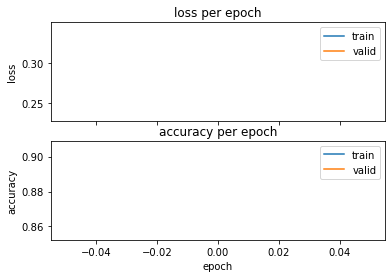

In [38]:
trainer.plot_statistics(statistics = stats)

##  Test the model : plot the loss, the accuracy and the confusion matrix

In [39]:
trainer.test(dump_id = "")

Test Loss: 0.223 | Test Acc: 91.08%


## Inference
We'll then use the model to test the sentiment of some sequences

In [40]:
predict = trainer.get_predict_sentiment() 

In [41]:
# example negative review...
print(predict(sentence = "This film is too scary, too much gunfire and blood spilled inside. I can't watch bad movies like this anymore."))
# example positive review...
print(predict(sentence = "Among these actors, I prefer the most romantic one, he likes what he does, is positive about chess and knows how to celebrate victories."))

NameError: name 'init_token_idx' is not defined